In [18]:
import sys
sys.path.append('../util')
sys.path.append('../')

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
import matplotlib.pyplot as plt
import numpy as np
from basic_TFIM_funcs import get_s_lists
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from scipy.optimize import curve_fit
#import Parallel:
from joblib import Parallel, delayed


In [12]:
#Rabi oscillations with time dependence:

def rabi_coeff(t, args):
    return args[0] + t*args[1]
sx, sy, sz = get_s_lists(1)
print(sx[0])
psi0 = basis(2, 0)

def genH(J, Jdt):
    def rabi_t(t, args):
        return rabi_coeff(t, [J, Jdt])
    return [[sx[0], rabi_t]]

results = mesolve(genH(1, 0.2), psi0, np.linspace(0, 10, 100), [], [sz[0]])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]


[ 1.          0.97925174  0.91624052  0.81129882  0.66691883  0.48789848
  0.28136284  0.05663596 -0.175056   -0.40105915 -0.60794048 -0.7822919
 -0.91165385 -0.98550507 -0.99624857 -0.94010981 -0.81785501 -0.63523562
 -0.40307333 -0.13691893  0.14375324  0.4168141   0.65916174  0.848715
  0.96656534  0.9990888   0.93978894  0.79063169  0.56264913  0.27563708
 -0.0431498  -0.36129841 -0.64439974 -0.85981    -0.98062721 -0.98940975
 -0.8811217  -0.66481407 -0.3636466  -0.01303258  0.34308081  0.65750601
  0.88611497  0.99434163  0.96293327  0.7919766   0.50235864  0.13412266
 -0.25838442 -0.61414982 -0.87495764 -0.99526751 -0.9508347  -0.7444004
 -0.40709513  0.00517462  0.42023285  0.76194463  0.96435644  0.98507703
  0.8151388   0.48296289  0.05099846 -0.39500676 -0.76255426 -0.97174406
 -0.97342552 -0.76195176 -0.37909624  0.09263075  0.5467084   0.8763222
  0.99996132  0.88275004  0.5477683   0.0735574  -0.42279539 -0.81385775
 -0.99483085 -0.91281376 -0.58399835 -0.09295332  0.4273

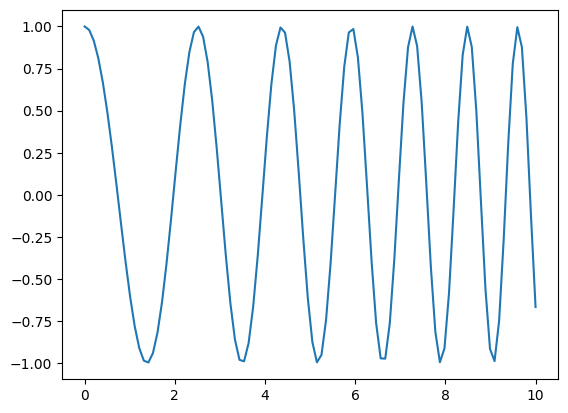

In [13]:
print(results.expect[0])
plt.plot(results.times, results.expect[0])

In [32]:
times = np.linspace(0, 10, 100)

In [33]:
#Generate dense theta simulation data:  from detune scanning




#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.0528
#theta_0 = 0
theta_dot = 0.024# * 1e3

print(times)
theta_f = theta_0 + theta_dot*max(times)#/1e3
print(theta_f)

#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

#t_list = np.linspace(0, max(times), 200)# * 1e-3
t_list = times
psi0 = tensor(basis(2,0), basis(2,1))


def J_func(J,i,j):
    return J*np.exp(-1*abs(i-j)+1)

def genH(theta_0, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    factor = (1 - delta)**2
    #HXX = sx[0]*0
    #for i in range(2):
    #    for j in range(i+1,2):
    #        HXX += J_func(J,i,j)*factor*(sx[i]*sx[j])
    HXX = J*sx[0]*sx[1]*factor
    
    #HXX = sum([ sum( [J(i,j)*factor*(sx[i]*sx[j]) of i in range(j+1,4)] for j in range(4)]))

    #HXX = J*factor*(sx[0]*sx[1]) 
    #print(HXX)
    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    #print(HB)

    return [HXX + HB]

def genHt(theta_0, theta_dot, J, B):
    delta = 0#thermal_rejection(theta_0,1)[0]
    def delta_func(t, args):
        updated_delta = delta + theta_dot*t#*10
        #print(t, updated_delta)
        return J#*(1- updated_delta)**2

    HXX = sx[0]*sx[1]#*factor

    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    return [[HXX,delta_func]]
    


#psi0 = tensor(basis(2,0), basis(2,0))
#yplus = (basis(2,0) + 1j*basis(2,1)).unit()
#minus = 
#psi0 = tensor(yplus, yplus)

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(J,B, obs = None, noise={}, time = t_list):
    xrate = 0
    zrate = 0
    theta_0 = 0
    try:
        xrate = noise['x']
    except:
        pass
    try:
        zrate = noise['z']
    except:
        pass
    try:
        theta_0 = noise['theta']
    except:
        pass
    #print(xrate)
    #print(zrate)
    #print(theta_0)
    #H = genH(theta_0,J,B)
    Ht = genHt(theta_0, theta_dot, J, B)
    noisy_ops = [sx[i]*xrate for i in range(2)]
    #noisy_ops = [sx[0]*xrate]
    #Sz_noise = (sz[0] * sz[1])*zrate#*sx[2]*sz[3])*zrate
    Sz_noise = [sz[i]*zrate for i in range(2)]
    #noisy_ops = []
    noisy_ops.append(Sz_noise)
    
    #results = mesolve(H, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    results = mesolve(Ht, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    return results
sim_shots = 600
#


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(J,B, obs=None, noise={}, time=t_list):
    #H = genH(theta_0, theta_dot)
    #run(theta_0, J,B)
    #print(noise)
    #full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, J,B,obs = obs, noise=noise, time=time) for _ in range(shots))
    #full_results = np.array([run(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots)])
    full_results = Parallel(n_jobs=6)(delayed(run)(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots))
    
    averaged = np.zeros(len(time))
    for item in full_results:
        #print(item.expect[0])
        averaged += sum(item.expect)
    averaged = averaged/sim_shots
    return averaged# + np.random.normal(0, 1/np.sqrt(sim_shots), len(time))
#fit leakage matrix to a line:
def linear(x, m, c):
    return m*x + c
#popt, pcov = curve_fit(linear, times[1:], leakage_matrix[1:,0])
#print(popt)
#intercept = 1-popt[1]
#slope = popt[0]
#plt.plot(times, leakage_matrix[:,0])
#plt.plot(times, linear(times, *popt))

def exp_fit(x, a, b, c):
    return a * np.exp(-b * x) + c

#popt, pcov = curve_fit(exp_fit, times[1:], leakage_matrix[1:,0], p0=[1, .05, -1])
#popt, pcov = curve_fit(exp_fit, times, leakage_matrix[:,0], p0=[1, -.04, -0.95])

#print(popt)
#plt.plot(times, leakage_matrix[:,0])
#plt.plot(times, exp_fit(times, *popt))


[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.18181818  8

In [53]:
J = np.pi
zeroZero = tensor(basis(2,0), basis(2,0))
oneOne = tensor(basis(2,1), basis(2,1))
zeroRho = zeroZero*zeroZero.dag()
oneRho = oneOne*oneOne.dag()
leakage_obs = [zeroRho, oneRho]#

oscillation_obs = [sz[0]/2, -1*sz[1]/2]
noise_dict = {'x':-1, 'z':0, 'theta':0}
results_Jij_oscillation = gen_full_results(J, 0, obs=oscillation_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
results_Jij_leakage = gen_full_results( J, 0, obs=leakage_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})


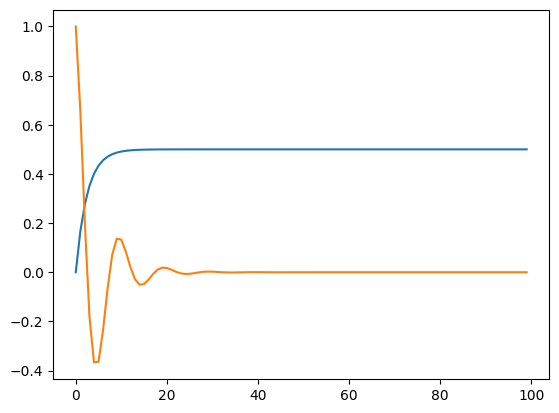

In [54]:
plt.plot(results_Jij_leakage)
plt.plot(results_Jij_oscillation)